# Predit pics
## import module

In [1]:
import torch 
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import torch.nn as nn
from PIL import Image

IMAGE_SIZE = 28
composed = transforms.Compose([transforms.Grayscale(num_output_channels=1), \
                               transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation = 2), \
                               transforms.ToTensor(),])


def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    
    
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('GPU is avalible')
else:
  device = torch.device('cpu')
  print('Training in CPU')
    
    

Training in CPU


## CNN
### loading model(invert)
<a href="https://www.researchgate.net/figure/Architecture-of-a-Convolutional-Neural-Network-CNN-The-traditional-CNN-structure-is_fig1_330106889"><img src="https://www.researchgate.net/publication/330106889/figure/fig1/AS:710963951063040@1546518423301/Architecture-of-a-Convolutional-Neural-Network-CNN-The-traditional-CNN-structure-is.png" alt="Architecture of a Convolutional Neural Network (CNN). The traditional CNN structure is mainly composed of convolution layers, pooling layers, fully connected layers, and some activation functions. Each convolution kernel is connected to the part of feature maps. The input is connected to all of the output elements in the fully connected layer."/></a>

In [2]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=64, out_2=128):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 7 * 7, 10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
model = CNN(out_1=64, out_2=128)
model.load_state_dict(torch.load('invert_color.pt', map_location=device)) #<--------------------change model

<All keys matched successfully>

### display pics

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1152x648 at 0x25CB6491C10>


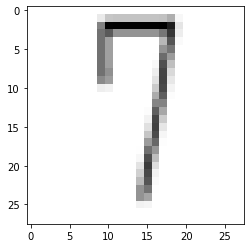

In [3]:
image = Image.open(r"D:\user\Documents\N26091194_TENG\Projects\MNIST\pics\77.jpg")#<-----change your pics path
print(image)
X = composed(image)
X = X[None, :, :]
show_data(X)

### Predict

In [4]:
model.eval()
z = model(X)
z = nn.functional.softmax(z, dim=1)
output = z.tolist()[0]
output_copy = output.copy()

for index, value in enumerate(output):
    print('推測 '+str(index)+' 的機率: {:.3} %'.format(value * 100))
print('-'*40)

print('預測結果 1st :', output.index(max(output_copy)))
output_copy.remove(max(output_copy))

print('預測結果 2nd :', output.index(max(output_copy)))
output_copy.remove(max(output_copy))

print('預測結果 3rd :', output.index(max(output_copy)))
output_copy.remove(max(output_copy))

print('-'*40)
print('預測為 :',output.index(max(output)))

# model: invert_color.pt
# error in black : 1, 3, 6, 7, 9 (acc: 50%)
# error in white : 0, 6, 7, 9 (acc: 60%)
# -------------------------------------

推測 0 的機率: 0.00159 %
推測 1 的機率: 96.7 %
推測 2 的機率: 0.488 %
推測 3 的機率: 0.00318 %
推測 4 的機率: 0.32 %
推測 5 的機率: 0.0546 %
推測 6 的機率: 0.00097 %
推測 7 的機率: 2.45 %
推測 8 的機率: 0.000287 %
推測 9 的機率: 0.00469 %
----------------------------------------
預測結果 1st : 1
預測結果 2nd : 7
預測結果 3rd : 2
----------------------------------------
預測為 : 1


## ResNet
### loading model
<a href="https://www.researchgate.net/figure/Proposed-Modified-ResNet-18-architecture-for-Bangla-HCR-In-the-diagram-conv-stands-for_fig1_323063171"><img src="https://www.researchgate.net/profile/Muhammad_Hasan19/publication/323063171/figure/fig1/AS:603178554904576@1520820382219/Proposed-Modified-ResNet-18-architecture-for-Bangla-HCR-In-the-diagram-conv-stands-for.png" alt="Proposed Modified ResNet-18 architecture for Bangla HCR. In the diagram, conv stands for Convolutional layer, Pool stands for MaxPool layer, batch norm stand for batch normalization, Relu stands for rectified linear unit activation layer, Sum stands for the addition in ResNet, and FC stand for fully connected hidden layers. In this architecture, we have eight ResNet modules which are modified by adding a dropout layer after the second convolutional layers."/></a>

In [5]:
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck

class MNISTResNet(ResNet):
    def __init__(self):
        super(MNISTResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10) # Based on ResNet18
        # super(MNISTResNet, self).__init__(BasicBlock, [3, 4, 6, 3], num_classes=10) # Based on ResNet34
        # super(MNISTResNet, self).__init__(Bottleneck, [3, 4, 6, 3], num_classes=10) # Based on ResNet50
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3,bias=False)

model = MNISTResNet()
model.load_state_dict(torch.load('ResNet', map_location=device))  #<--------------------change model

<All keys matched successfully>

### disply pic

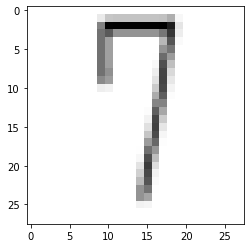

In [6]:
image = Image.open(r"D:\user\Documents\N26091194_TENG\Projects\MNIST\pics\77.jpg") #<-----change your pics path
X = composed(image)
X = X[None, :, :]
show_data(X)

### Predict

In [7]:
model.eval()
z = model(X)
z = nn.functional.softmax(z, dim=1)
output = z.tolist()[0]
output_copy = output.copy()

for index, value in enumerate(output):
    print('推測 '+str(index)+' 的機率: {:.3} %'.format(value * 100))
print('-'*40)

print('預測結果 1st :', output.index(max(output_copy)))
output_copy.remove(max(output_copy))

print('預測結果 2nd :', output.index(max(output_copy)))
output_copy.remove(max(output_copy))

print('預測結果 3rd :', output.index(max(output_copy)))
output_copy.remove(max(output_copy))

print('-'*40)
print('預測為 :',output.index(max(output)))
# model: ResNet
# error in black : 0, 3, 4, 5, 6, 7, 9 (acc: 30%)
# error in white : 6 (acc: 90%)
# -------------------------------------

推測 0 的機率: 0.256 %
推測 1 的機率: 41.5 %
推測 2 的機率: 0.335 %
推測 3 的機率: 0.437 %
推測 4 的機率: 0.387 %
推測 5 的機率: 0.588 %
推測 6 的機率: 0.0713 %
推測 7 的機率: 49.0 %
推測 8 的機率: 3.16 %
推測 9 的機率: 4.33 %
----------------------------------------
預測結果 1st : 7
預測結果 2nd : 1
預測結果 3rd : 9
----------------------------------------
預測為 : 7
